# Goal: To scale the rat to the size of a mouse 
- Make sure the ratio of non-zero pixels and zero pixels are the same
- Two constraints: area matches, and ratio of zero to non-zero pixels matches. 
- First get rat down to 80x80 frame by downsampling
- Then, resize rat to make it same size as mouse in 80x80 frame

In [24]:
from rat_moseq.organization import get_rat_h5s, get_mouse_h5s
from rat_moseq.size import downsample, resize_video, compute_changepoints
from tqdm import tqdm
import h5py
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

In [2]:
rat_key = 'frames_v2'
rat_h5s = get_rat_h5s(check=True, key=rat_key)
rat_h5s = np.random.choice(rat_h5s, size=50)

mouse_h5s = get_mouse_h5s()
mouse_h5s = [h5 for h5 in mouse_h5s if 'saline' in str(h5)]

### down sample rats to 80x80

In [19]:
dset = np.random.choice(list(downsampled.keys()))
# frames = downsampled[dset]
frames = h5py.File(rat_h5s[0], 'r')['frames'][()]

dead_path = '/n/groups/datta/jlove/data/rat_seq/wk14/data_dead/dead_rat'
dead_h5s = list(Path(dead_path).glob('**/proc/results_00.h5'))
dead_frames = h5py.File(dead_h5s[-2], 'r')['frames'][()]

In [20]:
factors = np.linspace(.1, 1, 10)
changecounts = {}
dead_changecounts = {}

for factor in tqdm(factors, total=len(factors)):
    tmp = resize_video(frames, factor)
    tmp_dead = resize_video(dead_frames, factor)

    cp, _, _ = compute_changepoints(tmp)
    dead_cp, _, _ = compute_changepoints(tmp_dead)
    
    tmp = (cp>.5).sum()
    tmp_dead = (dead_cp>.5).sum()

    changecounts[factor] = tmp
    dead_changecounts[factor] = tmp_dead

100%|██████████| 10/10 [10:06<00:00, 60.61s/it]


In [21]:
count_df = pd.DataFrame(
    dict(factor=changecounts.keys(),
         count=changecounts.values(),
         dead='alive'
    )
)
dead_df = pd.DataFrame(
    dict(factor=dead_changecounts.keys(),
         count=dead_changecounts.values(),
         dead='dead'
    )
)
count_df = pd.concat([count_df, dead_df])

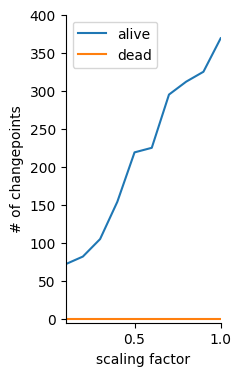

In [31]:
plt.figure(figsize=(2,4))
sns.lineplot(
    data=count_df,
    x='factor',
    y='count',
    hue='dead'
)
sns.despine()
ax = plt.gca()
ax.set_xlim(0.1, 1)   
ax.set_ylim(-5, 400)
ax.set_xlabel('scaling factor')
ax.set_ylabel('# of changepoints')
ax.legend()